# 04 Tree Ensembles (RandomForest, XGBoost) + SHAP

Tunes tree models on sparse features and produces SHAP explanations.

In [1]:
%run ./00_shared_utils.ipynb
# %pip install -q xgboost shap  # Uncomment if needed when running locally

import pandas as pd, numpy as np, json, joblib
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from scipy import sparse

set_seeds()

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Shared utilities loaded. Use build_full_pipeline(classifier) to create a text model pipeline.


RF Macro-F1: 0.7107909524994319


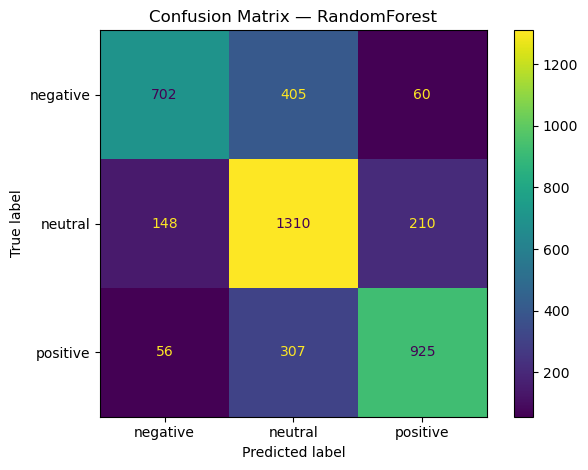

['model_registry/rf_pipeline.joblib']

In [2]:
try:
    import xgboost as xgb
    has_xgb = True
except Exception as e:
    print("xgboost not available — you can install it and rerun.")
    has_xgb = False

DATA_PATH = Path('data/Tweets.csv')
df = pd.read_csv(DATA_PATH)
X = df[['text','selected_text']]
y = df['sentiment']

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.15, random_state=RANDOM_STATE, stratify=y)

le = LabelEncoder()
y_tr_enc = le.fit_transform(y_tr)
y_te_enc = le.transform(y_te)


feat_pipe = Pipeline([('clean', CleaningTransformer()), ('feats', build_feature_union())])
Xtr = feat_pipe.fit_transform(X_tr, y_tr)
Xte = feat_pipe.transform(X_te)

rf = RandomForestClassifier(n_estimators=300, max_depth=None, n_jobs=-1, random_state=RANDOM_STATE, class_weight='balanced_subsample')
rf.fit(Xtr, y_tr)
y_pred = rf.predict(Xte)
f1m = f1_score(y_te, y_pred, average='macro')
print("RF Macro-F1:", f1m)

cm = confusion_matrix(y_te, y_pred, labels=rf.classes_)
ConfusionMatrixDisplay(cm, display_labels=rf.classes_).plot()
plt.title('Confusion Matrix — RandomForest')
plt.tight_layout()
plt.savefig('artifacts/rf_confusion_matrix.png')
plt.show()

joblib.dump({'features': feat_pipe, 'clf': rf}, 'model_registry/rf_pipeline.joblib')

XGB Macro-F1: 0.7816753906660469


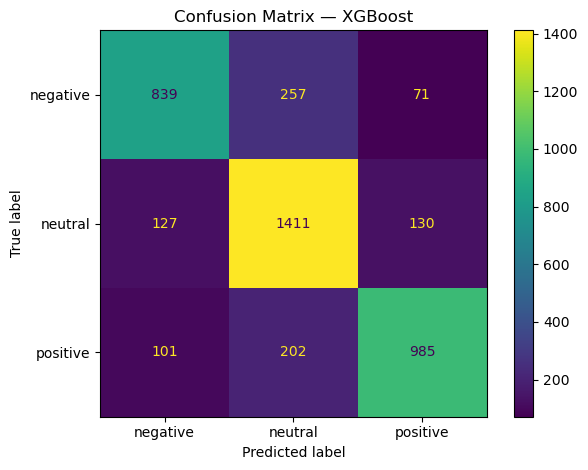

SHAP not available or failed: The passed model is not callable and cannot be analyzed directly with the given masker! Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=-1,
              num_parallel_tree=None, ...)


In [3]:
if has_xgb:
    xg = xgb.XGBClassifier(
        n_estimators=500, max_depth=6, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8,
        objective='multi:softprob', eval_metric='mlogloss', random_state=RANDOM_STATE, n_jobs=-1
    )
    xg.fit(Xtr, y_tr_enc)
    y_pred_enc = xg.predict(Xte)
    y_pred = le.inverse_transform(y_pred_enc)
    f1m = f1_score(y_te, y_pred, average='macro')
    print("XGB Macro-F1:", f1m)
    cm = confusion_matrix(y_te, y_pred, labels=le.classes_)
    ConfusionMatrixDisplay(cm, display_labels=le.classes_).plot()
    plt.title('Confusion Matrix — XGBoost')
    plt.tight_layout()
    plt.savefig('artifacts/xgb_confusion_matrix.png')
    plt.show()
    joblib.dump({'features': feat_pipe, 'clf': xg, 'label_encoder': le}, 'model_registry/xgb_pipeline.joblib')

try:
    import shap
    if has_xgb:
        explainer = shap.Explainer(xg, Xtr, feature_names=None)
        shap_values = explainer(Xte[:200])
        plt.figure()
        shap.plots.beeswarm(shap_values, show=False)
        plt.tight_layout()
        plt.savefig('artifacts/xgb_shap_beeswarm.png')
        plt.show()
    else:
        print("SHAP skipped (needs xgboost installed)." )
except Exception as e:
    print("SHAP not available or failed:", e)